In [90]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from sklearn.metrics import mean_squared_error


In [8]:
import tensorflow as tf

### Getting the Data from tiingo API

In [2]:
tiingo_key = "##############################"

In [3]:
df = pdr.get_data_tiingo('AMZN',api_key=tiingo_key)

In [5]:
df.to_csv('amazon.csv')

In [9]:
df = df.reset_index()

In [11]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AMZN,2019-08-22 00:00:00+00:00,1804.66,1829.41,1800.10,1828.00,2658388,90.2330,91.4705,90.0050,91.4000,53167760,0.0,1.0
1,AMZN,2019-08-23 00:00:00+00:00,1749.62,1804.90,1745.23,1793.03,5277898,87.4810,90.2450,87.2615,89.6515,105557960,0.0,1.0
2,AMZN,2019-08-26 00:00:00+00:00,1768.87,1770.00,1743.51,1766.91,3085320,88.4435,88.5000,87.1755,88.3455,61706400,0.0,1.0
3,AMZN,2019-08-27 00:00:00+00:00,1761.83,1779.40,1746.68,1775.73,3027245,88.0915,88.9700,87.3340,88.7865,60544900,0.0,1.0
4,AMZN,2019-08-28 00:00:00+00:00,1764.25,1767.86,1744.05,1755.00,2411125,88.2125,88.3930,87.2025,87.7500,48222500,0.0,1.0


In [12]:
data = df[['date','open']]

In [13]:
data

,date,open
0,2019-08-22 00:00:00+00:00,1828.00
1,2019-08-23 00:00:00+00:00,1793.03
2,2019-08-26 00:00:00+00:00,1766.91
3,2019-08-27 00:00:00+00:00,1775.73
4,2019-08-28 00:00:00+00:00,1755.00
...,...,...
1252,2024-08-14 00:00:00+00:00,172.11
1253,2024-08-15 00:00:00+00:00,174.86
1254,2024-08-16 00:00:00+00:00,177.04
1255,2024-08-19 00:00:00+00:00,177.64


### Preprocessing the data

In [15]:
open_price = data['open']

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))

open_price_scaled = scaler.fit_transform(np.array(open_price).reshape(-1,1))


In [28]:
#train-test split. Using 70-30

train_index_ends = int(len(open_price_scaled)*0.70)

train_data = open_price_scaled[0:train_index_ends+1]
test_data = open_price_scaled[train_index_ends:]

In [113]:
train_index_ends

879

In [55]:
# One of the important parameters in time series is the timestep. In fact, it is a tunable parameter - a hyperparameter.

def prepare_data_by_timestep(input_array_sequence,timestep):

    x_data = []
    y_data = []

    for i in range(len(input_array_sequence)-timestep-1):

        feature = input_array_sequence[i:i+timestep,0]
        label = input_array_sequence[i+timestep,0]

        x_data.append(feature)
        y_data.append(label)

    return np.array(x_data), np.array(y_data)

In [56]:
X_train, y_train = prepare_data_by_timestep(train_data,timestep=100)
X_test, y_test = prepare_data_by_timestep(test_data,timestep=100)

### The expected input format of an LSTM is that it is shaped as [batch_size,timesteps,num_of_features], batch_size in this case would be how many sequences are present in both train and test set. timesteps, would be 100 (since we processed data such that each continuous sequence of 100 opening prices are used to predict the 101st price ) and num_of_features would be 1 in this case (since we are only working with opening price)


In [67]:

# reshaping the train and test data as required

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### Building a stacked LSTM model by using multiple LSTM layers one after another.

In [70]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))  # First LSTM layer
model.add(LSTM(50, return_sequences=True))  # Second LSTM layer
model.add(LSTM(50))  # Third LSTM layer, return_sequences=False by default
model.add(Dense(1))  # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')


In [71]:
model_history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 14s 607ms/step - loss: 0.1327 - val_loss: 0.0093
Epoch 2/100
13/13 [==============================] - 6s 499ms/step - loss: 0.0242 - val_loss: 0.0133
Epoch 3/100
13/13 [==============================] - 6s 495ms/step - loss: 0.0124 - val_loss: 9.6915e-04
Epoch 4/100
13/13 [==============================] - 6s 457ms/step - loss: 0.0076 - val_loss: 2.8831e-04
Epoch 5/100
13/13 [==============================] - 5s 414ms/step - loss: 0.0068 - val_loss: 8.8015e-04
Epoch 6/100
13/13 [==============================] - 6s 426ms/step - loss: 0.0061 - val_loss: 4.5931e-04
Epoch 7/100
13/13 [==============================] - 6s 437ms/step - loss: 0.0057 - val_loss: 2.2580e-04
Epoch 8/100
13/13 [==============================] - 7s 508ms/step - loss: 0.0053 - val_loss: 1.7415e-04
Epoch 9/100
13/13 [==============================] - 6s 475ms/step - loss: 0.0051 - val_loss: 1.9223e-04
Epoch 10/100
13/13 [==============================] - 6s 444ms

In [76]:
train_loss, val_loss = model_history.history['loss'], model_history.history['val_loss']

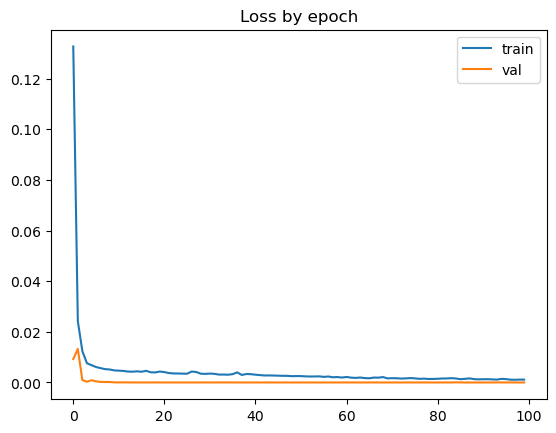

In [81]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
plt.legend()
plt.title('Loss by epoch');

### Using the model to predict on both - train data and test data 

In [84]:
train_pred = model.predict(X_train)

25/25 [==============================] - 2s 41ms/step


In [86]:
test_pred = model.predict(X_test)

9/9 [==============================] - 0s 43ms/step


### The prediction output needs to be scaled back inversely so that I can look at the evaluation metrics

In [87]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

### Now, let's look at the RMSE

In [121]:
train_pred = train_pred.reshape((779))
test_pred = test_pred.reshape((277))

In [129]:
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

In [137]:
train_rmse = np.sqrt(mean_squared_error(train_pred,y_train_actual.reshape(-1)))
test_rmse = np.sqrt(mean_squared_error(test_pred,y_test_actual.reshape(-1)))

In [138]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 125.54047040100406
Test RMSE: 7.677903357359015


### Strangely,  the train rmse is significantly higher than the test rmse. I believe it can be because :
1. The training data actually has more number of values that are much higher than the less number of values in test data

### The plot below shows the difference between actual values of the same stock. Due to the stock price for Amazon being volatile, it can be seen that whatever the time duration range was for the whole data, during initial days, the stock actually had a value in 2000s until it suddenly dropped to 100s 

Text(0.5, 1.0, 'test data value distribution')

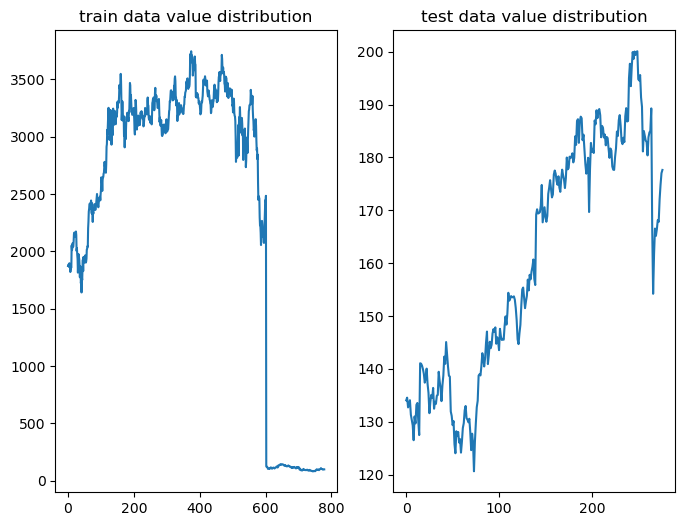

In [150]:
fig,ax  = plt.subplots(1,2,figsize=(8,6))

ax[0].plot(y_train_actual.reshape(-1))
ax[0].set_title("train data value distribution")

ax[1].plot(y_test_actual.reshape(-1))
ax[1].set_title("test data value distribution")


### Let's plot the original closing prices and predicted (both train and test) closing prices for the Amazon stock price

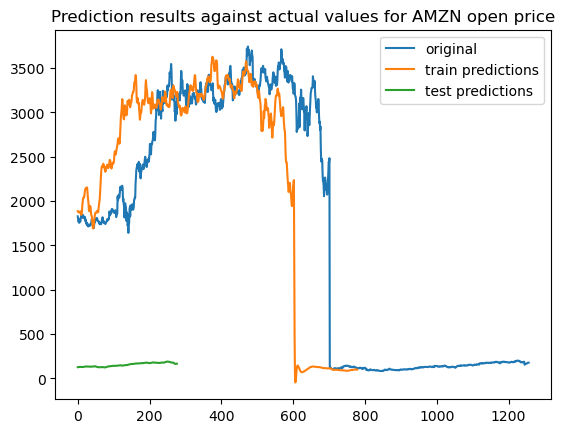

In [181]:
plt.plot(open_price,label='original')
plt.plot(train_pred,label="train predictions")
plt.plot(test_pred,label="test predictions")
plt.title('Prediction results against actual values for AMZN open price')
plt.legend()
plt.show()

### Apparently, the prediction plots need to be shifted so that predictions are imposed on the training plot to better understand the performance visually.

In [161]:
#creating a numpy array to hold all the values (train+test)a
train_prediction_data_shifted = np.empty_like(open_price)

#filling the numpy array with nan so that the values that were not used for predictions can still be plotted as nothing on the plot
train_prediction_data_shifted[:] = np.nan

#filling the index locations that correspond to the train prediction values ( remember, the timestep used was 100)
train_prediction_data_shifted[100:len(train_pred)+100] = train_pred






#### To find the index for test predictions in shifted array, remember that the test predictions will start from the location where train predictions end i.e at len(open_price)-len(train_pred)

In [175]:
#doing the same for test predictions
test_prediction_data_shifted = np.empty_like(open_price)
test_prediction_data_shifted[:] = np.nan
test_prediction_data_shifted[len(open_price)-len(test_pred):] = test_pred

In [162]:
train_prediction_data_shifted.shape

(1257,)

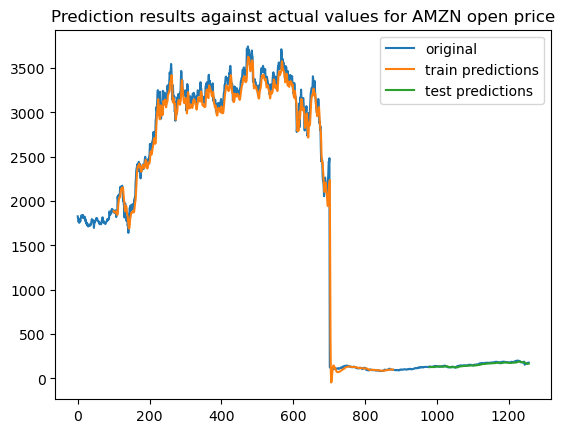

In [180]:
plt.plot(open_price,label='original')
plt.plot(train_prediction_data_shifted,label='train predictions')
plt.plot(test_prediction_data_shifted,label='test predictions')
plt.title('Prediction results against actual values for AMZN open price')
plt.legend()
plt.show()



### As mentioned above, the predictions for test data are more aligned with the original data than the predictions for train data. Again, I believe, because of the difference in the open price values of the stock price. One of the future goals for me is to train the model for higher timesteps so that it learns from a bigger range of values thus taking into account the extremely volatile nature of stock prices.

### For now, let's predict the prices for next 30 days using this trained model

In [183]:
test_data.shape

(378, 1)

In [184]:
len(test_data)

378

### The logic for predicting fututre values is straightforward.
1. Start with the last 100 values as input (1-100)
2. Use those last 100 values to predict the 101st value
3. Add the 101st value to the input
4. Take the new input as 2-101 
5. Use the new input to predict the 102nd value
6. Repeat steps 2-5 'n' number of times where n = number of timesteps in fututre you want to predict

In [187]:
#getting the last 100 values from the dataset.
X_30_input = test_data[len(test_data)-100:].reshape(1,-1)


In [204]:
# predictions for next 30 days.

outputs = []
model_input = X_30_input.copy()
i = 0

while(i<30):

    if (len(X_30_input)>30):

        model_temp_input = np.array(model_input[-100:])
        model_temp_input = model_temp_input.reshape(-1,1)
        model_temp_input = model_temp_input.reshape(1,100,1) #reshaping the input in [batch_size,num of samples,num of features]
        model_output = model.predict(model_temp_input,verbose=1)
        model_input.extend(list(model_output[0])) #adding the predicted value to the input
        outputs.extend(list(model_output))
        print(f'Predicting {i}th value')
        print(f'Predicted {i}th Value: {model_output[0]}',end='\n\n')
        i += 1
        




    
    #the else condition will only be reached for the first time
    else:
        model_temp_input = model_input.reshape(1,100,1) #reshaping the input in [batch_size,num of samples,num of features]
        model_output = model.predict(model_temp_input,verbose=1) 
        model_input.extend(list(model_output[0])) #adding the predicted value to the input
        outputs.extend(list(model_output))
        print(f'Predicting {i}th value')
        print(f'Predicted {i}th Value: {model_output[0]}',end='\n\n')
        i += 1
        

1/1 [==============================] - 0s 16ms/step
Predicting 0th value
Predicted 0th Value: [0.02353645]

1/1 [==============================] - 0s 16ms/step
Predicting 1th value
Predicted 1th Value: [0.02358392]

1/1 [==============================] - 0s 16ms/step
Predicting 2th value
Predicted 2th Value: [0.02341183]

1/1 [==============================] - 0s 17ms/step
Predicting 3th value
Predicted 3th Value: [0.02311573]

1/1 [==============================] - 0s 15ms/step
Predicting 4th value
Predicted 4th Value: [0.02277068]

1/1 [==============================] - 0s 17ms/step
Predicting 5th value
Predicted 5th Value: [0.02242053]

1/1 [==============================] - 0s 17ms/step
Predicting 6th value
Predicted 6th Value: [0.02208601]

1/1 [==============================] - 0s 17ms/step
Predicting 7th value
Predicted 7th Value: [0.02177452]

1/1 [==============================] - 0s 15ms/step
Predicting 8th value
Predicted 8th Value: [0.02148685]

1/1 [=======================

In [209]:
next_30_preds = np.array(outputs)

In [219]:
next_30_preds = next_30_preds.reshape(-1)

#inverse scale the outputs 
next_30_preds = scaler.inverse_transform(next_30_preds.reshape(-1,1))

In [224]:
final_preds = next_30_preds.reshape(-1)

### Now in order to plot the forecasted results, the predictions must be shifted to better visualize them.

In [251]:
len(open_price)

1257

In [252]:
forecast = np.full(1257+30,np.nan)
forecast[1257:] = final_preds

In [254]:
forecast.shape

(1287,)

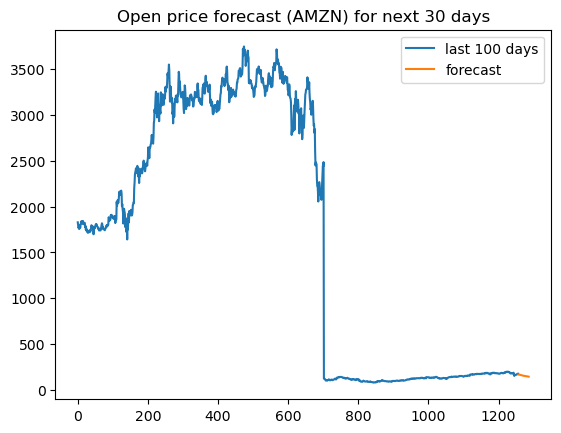

In [260]:
plt.plot(open_price,label='last 100 days')
plt.plot(forecast,label='forecast')
plt.legend()
plt.title('Open price forecast (AMZN) for next 30 days')
plt.show()

### Plotting the forecast with a zoomed in scale to better understand the trend


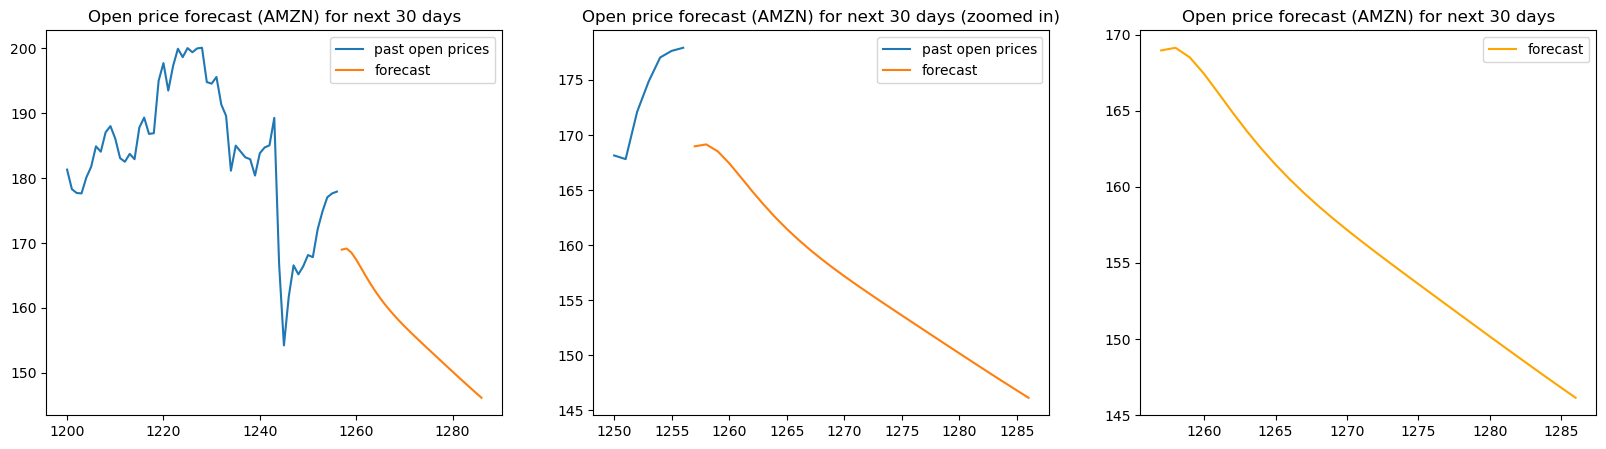

In [266]:
fig2,ax2  = plt.subplots(1,3,figsize=(20,5))

ax2[0].plot(open_price[1200:],label='past open prices')
ax2[0].plot(forecast,label='forecast')
ax2[0].set_title('Open price forecast (AMZN) for next 30 days')
ax2[0].legend()


ax2[1].plot(open_price[1250:],label='past open prices')
ax2[1].plot(forecast,label='forecast')
ax2[1].set_title('Open price forecast (AMZN) for next 30 days (zoomed in)')
ax2[1].legend()


ax2[2].plot(forecast,label='forecast',color = 'orange')
ax2[2].set_title('Open price forecast (AMZN) for next 30 days')
ax2[2].legend()
plt.show()